# Channel-Layer-Oriented Lightweight Spectral-Spatial Network for Hyperspectral Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.model_selection
from torch.nn import init
from torch.backends import cudnn
from operator import truediv
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from timm.layers import weight_init, DropPath
from timm.models.registry import register_model
import random
import time
from thop import profile
from torchsummary import summary
device = torch.device('cuda:{}'.format(0))
random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
np.random.seed(7)
cudnn.deterministic = True

# 1. Load data

## 1.1 Load img and gt as numpy.ndarray

In [2]:
datasets = {
        'PaviaU': {
            'img': 'PaviaU.mat',      #paviaU
            'gt': 'PaviaU_gt.mat'     #paviaU_gt
            },
        'houston2013':{
            'img': 'houston2013.mat', # houston2013
            'gt': 'DFC2013_gt.mat'# DFC2013_gt
        },
        'salinas':{
            'img': 'Salinas.mat', # salinas
            'gt': 'Salinas_gt.mat'# salinas_gt
        },
        'WHHC':{
            'img': 'hanchuan_half.mat', # hanchuan_half
            'gt': 'hanchuan_half_gt.mat'# half_new
        },
        'Dioni':{
            'img': 'Dioni.mat', # ori_data
            'gt': 'Dioni_gt_out68.mat'# map
        } 
}
dataset_name='Dioni'
dataset=datasets[dataset_name]
folder = './Datasets/'
img = io.loadmat(folder+dataset['img'])['ori_data']   

img= (img - np.min(img))/(np.max(img)-np.min(img))  
print(type(img),img.shape)
gt = io.loadmat(folder + dataset['gt'])['map']

<class 'numpy.ndarray'> (250, 1376, 176)


## 1.2 Visualization

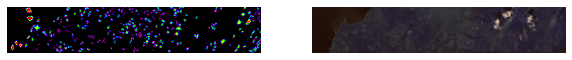

In [3]:
N_CLASSES = max(np.unique(gt))
N_BANDS = img.shape[-1]      
fig=plt.figure(num=1,figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(gt,cmap='nipy_spectral')
plt.axis('off')
plt.subplot(2,2,2)
# plt.imshow(img[:,:,(10, 50, 100)]) 
plt.imshow(img[:,:,(10, 20, 30)]) 
plt.axis('off')
plt.show()

## 1.3 Training set ,validation set and test set split

In [4]:
indices = np.nonzero(gt)
X = list(zip(*indices))
y = gt[indices] 
train_gt = np.zeros_like(gt)
test_gt = np.zeros_like(gt)
val_gt = np.zeros_like(gt)
print('train_gt: ',type(train_gt),train_gt.shape)

train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=0.03, random_state=12,stratify=y)

val_size = len(train_indices)
val_indices = test_indices[-val_size:]
test_indices = test_indices[:-val_size]

train_size = len(train_indices)
train_indices = list(zip(*train_indices))
val_indices = list(zip(*val_indices))
test_indices = list(zip(*test_indices))

train_gt[train_indices] = gt[train_indices]
val_gt[val_indices] = gt[val_indices]
test_gt[test_indices] = gt[test_indices]

# GHOSTNET&LS2CM Training set for hous2013
# train_gt = io.loadmat(folder+'TR_hous2013_5.mat')['Tr1'] 
# val_gt = io.loadmat(folder+'TV_hous2013_5.mat')['Tv1'] 
# test_gt = io.loadmat(folder+'TE_hous2013_5.mat')['Te_new1'] 


train_gt:  <class 'numpy.ndarray'> (250, 1376)


D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\anaconda3\envs\pytorch_envs\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

## 1.4 Define dataloader

In [5]:
class HSIdata(torch.utils.data.Dataset):
    def __init__(self,data,gt):
        super(HSIdata, self).__init__()
        self.data = data   
        self.label = gt-1
        self.patch_size = 13
        self.data_all_offset = np.zeros((data.shape[0] + self.patch_size - 1, self.data.shape[1] + self.patch_size - 1, self.data.shape[2]))
        self.start = int((self.patch_size - 1) / 2)
        self.data_all_offset[self.start:data.shape[0] + self.start, self.start:data.shape[1] + self.start, :] = self.data[:, :, :]
        x_pos, y_pos = np.nonzero(gt)
    
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        self.labels = [self.label[x,y] for x,y in self.indices]
        
#         np.random.shuffle(self.indices)
        
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data_all_offset[x:x+self.patch_size, y:y+self.patch_size]
        label = self.label[x, y]
        data = np.asarray(data.transpose((2, 0, 1)), dtype='float32')
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
#         print(type(data[6,6,1]),data.shape)
#         print(label)
        return data, label,x,y

train_dataset = HSIdata(img, train_gt)
train_loader = torch.utils.data.DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=True)

val_dataset = HSIdata(img, val_gt)
val_loader = torch.utils.data.DataLoader(val_dataset,
                               batch_size=32,
                               shuffle=True)

test_dataset = HSIdata(img, test_gt)
test_loader = torch.utils.data.DataLoader(test_dataset,
                               batch_size=256,
                               shuffle=True)

all_gt_dataset = HSIdata(img,gt)
all_loader = torch.utils.data.DataLoader(all_gt_dataset,
                               batch_size=256,
                               shuffle=True)


# 2. Define Network structure 

In [6]:
class SELayer(nn.Module):

    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        out = channel // reduction
        if out == 0:
            out = 1
        self.fc = nn.Sequential(
            nn.Linear(channel, out, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(out, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y=self.avg_pool(x).view(b,c)
        y=self.fc(y).view(b,c,1,1)
        return x*y.expand_as(x)
    
class COS2M(nn.Module):
    def __init__(self, input_channels ,reduction_N = 16):
        super(COS2M, self).__init__()
        self.point_wise = nn.Conv2d(input_channels,reduction_N,kernel_size=1,padding=0,bias=False)
        self.depth_wise = nn.Conv2d(reduction_N, reduction_N, kernel_size=3, padding=1, groups=reduction_N, bias=False)      
        self.conv3D = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=(1,1,3),padding=(0,0,1),stride=(1,1,1),bias=False)
        self.bn = nn.BatchNorm2d(reduction_N)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x_1 = self.point_wise(x)  
        x_2 = self.depth_wise(x_1)
        #DSC
        x_3 = x_1.unsqueeze(1)
        x_3 = self.conv3D(x_3)
        x_3 = x_3.squeeze(1)
        
        x = torch.cat((x_2,x_3),dim=1)
        
        return x

class NPAF(nn.ReLU):
    def __init__(self, dim, act_num=1):
        super(NPAF, self).__init__()
        self.act_num = act_num
        self.dim = dim
        self.weight = torch.nn.Parameter(torch.randn(dim, 1, act_num*2 + 1, act_num*2 + 1))
        self.bias = None
        self.bn = nn.BatchNorm2d(dim, eps=1e-6)
        weight_init.trunc_normal_(self.weight, std=.02)

    def forward(self, x):
        return self.bn(torch.nn.functional.conv2d(
            super(NPAF, self).forward(x),
            self.weight, padding=self.act_num, groups=self.dim))


class BaseNet(nn.Module):

    def __init__(self, input_channels, n_classes, dropout=True):
        super(BaseNet, self).__init__()
        self.use_dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.4)
          
        self.lwm = COS2M(input_channels)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.act1 = NPAF(32)

        self.lwm2 = COS2M(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.se0 = SELayer(32)  
               
        self.conv3 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0, bias=False)
        self.mask3 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0, bias=False)
#         self.mask3.weight.data = torch.ones(self.mask3.weight.size())
        self.bn3 = nn.BatchNorm2d(16)
        self.act2 = NPAF(16)
        self.se1 = SELayer(16)
    
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(16, n_classes ,bias=False)

    def forward(self, x):

        x1 = self.lwm(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)

        x2 = self.lwm2(x1)
        x2 = self.bn2(x2)
        x2 = self.act1(x2)
        x2=self.se0(x2)
        
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = self.act2(x3)
        x3=self.se1(x3)
        if self.use_dropout:
            x3 = self.dropout(x3)
            
        x3 = self.avgpool(x3)
        x3 = x3.view(x3.size(0), -1)
        x3 = self.fc1(x3)
        
        return x3


# 3. Utils

In [7]:
def save_model(model, model_name, dataset_name, epoch):
    model_dir = './checkpoints/' + model_name + "/" + dataset_name + "/"
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    filename = str('w6') + "_epoch{}".format(epoch)
    print(filename)
    torch.save(model.state_dict(), model_dir + filename + '.pth')
    
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

# 4. Train define

In [8]:
def evaluate_accuracy(data_loader, net, loss):
#     val_loss = 0
    number = 0
    acc_sum = 0   
    test_num = 0
    with torch.no_grad():
        for iter_, (data, target,x,y) in enumerate(data_loader):
            val_loss = 0
            data, target = data.to(device), target.to(device)            
            net.eval()
            output = net(data)
            l = loss(output, target.long())
            acc_sum += (output.argmax(dim=1) == target.to(device)).float().sum().cpu().item()          
#             l = loss(output, target)
#             _, predicts = torch.max(output.data, 1)
            val_loss = val_loss + l
            number += len(target)
#             correct = correct + (predicts == target).sum()
            net.train()
            test_num += 1
        
    return [acc_sum / number, val_loss.cpu()]


def train(net, optimizer, critirian, data_loader, val_loader, epoch):
    loss_list = [1000]
    early_epoch = 0
    early_num = 20 
    early_stopping = 1
    train_loss_list = []
    valida_loss_list = []
    train_acc_list = []
    valida_acc_list = []
    net.to(device)
    for e in range(1, epoch + 1):
        net.train()
        lr_adjust = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)
        avg_loss = 0
        number = 0
        correct = 0
        for iter_, (data, target,x,y) in enumerate(data_loader):
            batch_count, train_l_sum = 0, 0
            data, target = data.to(device), target.to(device)            
            optimizer.zero_grad()
            output = net(data)
            #             print(target)
            loss = critirian(output, target)
            loss.backward()
            optimizer.step()
            _, predicts = torch.max(output.data, 1)
            avg_loss = avg_loss + loss.item()
            number += len(target)
            correct = correct + (predicts == target).sum()
            
        lr_adjust.step(epoch)
        valida_acc, valida_loss = evaluate_accuracy(val_loader, net, critirian)
        loss_list.append(valida_loss)
        avg_loss /= len(data_loader)     
        print('train--------')
#         print('Epoch:', e, 'loss:', avg_loss)
        acc = correct.item() / number
    
        train_loss_list.append(avg_loss)
        train_acc_list.append(acc)
        valida_loss_list.append(valida_loss)
        valida_acc_list.append(valida_acc)

#         print('Epoch:', e, 'acc:', acc)
        print('epoch %d, train loss %.6f, train acc %.3f, valida  loss %.6f, valida acc %.3f'% (e + 1, avg_loss, acc, valida_loss, valida_acc))    
#         filename = str('LW') + "_epoch{}".format(e)
        PATH = "./LW_best_net.pt"
        global best_acc
        if valida_acc > best_acc:
            best_acc = valida_acc
            torch.save(net.state_dict(), PATH)
        if e == epoch:
            net.load_state_dict(torch.load(PATH))      
   
        if e % 100 == 0:
            save_model(net, 'basenet', dataset_name, e)
            


# 5.TRAIN & TEST

D:\anaconda3\envs\pytorch_envs\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train--------
epoch 2, train loss 2.235782, train acc 0.377, valida  loss 2.480609, valida acc 0.267
train--------
epoch 3, train loss 1.970488, train acc 0.582, valida  loss 2.452035, valida acc 0.065
train--------
epoch 4, train loss 1.789914, train acc 0.618, valida  loss 2.121393, valida acc 0.568
train--------
epoch 5, train loss 1.681280, train acc 0.603, valida  loss 2.599435, valida acc 0.167
train--------
epoch 6, train loss 1.503238, train acc 0.637, valida  loss 2.705764, valida acc 0.120
train--------
epoch 7, train loss 1.389446, train acc 0.630, valida  loss 1.896819, valida acc 0.365
train--------
epoch 8, train loss 1.255589, train acc 0.667, valida  loss 1.147845, valida acc 0.503
train--------
epoch 9, train loss 1.224082, train acc 0.667, valida  loss 1.288540, valida acc 0.597
train--------
epoch 10, train loss 1.188152, train acc 0.658, valida  loss 1.452207, valida acc 0.532
train--------
epoch 11, train loss 1.096834, train acc 0.667, valida  loss 3.071164, valid

train--------
epoch 83, train loss 0.214585, train acc 0.942, valida  loss 1.688010, valida acc 0.572
train--------
epoch 84, train loss 0.215011, train acc 0.935, valida  loss 0.836645, valida acc 0.760
train--------
epoch 85, train loss 0.250199, train acc 0.915, valida  loss 0.667072, valida acc 0.853
train--------
epoch 86, train loss 0.230091, train acc 0.922, valida  loss 3.278913, valida acc 0.640
train--------
epoch 87, train loss 0.283027, train acc 0.903, valida  loss 1.924891, valida acc 0.372
train--------
epoch 88, train loss 0.213438, train acc 0.945, valida  loss 1.917436, valida acc 0.607
train--------
epoch 89, train loss 0.215811, train acc 0.925, valida  loss 0.271955, valida acc 0.877
train--------
epoch 90, train loss 0.190489, train acc 0.937, valida  loss 2.135188, valida acc 0.698
train--------
epoch 91, train loss 0.226112, train acc 0.928, valida  loss 0.220423, valida acc 0.885
train--------
epoch 92, train loss 0.217471, train acc 0.930, valida  loss 1.43752

train--------
epoch 163, train loss 0.202417, train acc 0.937, valida  loss 1.750666, valida acc 0.575
train--------
epoch 164, train loss 0.160886, train acc 0.937, valida  loss 0.155831, valida acc 0.910
train--------
epoch 165, train loss 0.086068, train acc 0.975, valida  loss 2.298952, valida acc 0.392
train--------
epoch 166, train loss 0.193363, train acc 0.927, valida  loss 6.841286, valida acc 0.417
train--------
epoch 167, train loss 0.130957, train acc 0.957, valida  loss 1.569147, valida acc 0.707
train--------
epoch 168, train loss 0.145744, train acc 0.950, valida  loss 3.160357, valida acc 0.308
train--------
epoch 169, train loss 0.184638, train acc 0.925, valida  loss 3.082942, valida acc 0.513
train--------
epoch 170, train loss 0.098617, train acc 0.975, valida  loss 0.478990, valida acc 0.918
train--------
epoch 171, train loss 0.131792, train acc 0.950, valida  loss 1.079214, valida acc 0.613
train--------
epoch 172, train loss 0.157307, train acc 0.952, valida  lo

train--------
epoch 243, train loss 0.052055, train acc 0.988, valida  loss 0.432662, valida acc 0.870
train--------
epoch 244, train loss 0.104303, train acc 0.965, valida  loss 35.929787, valida acc 0.125
train--------
epoch 245, train loss 0.051191, train acc 0.987, valida  loss 0.786124, valida acc 0.713
train--------
epoch 246, train loss 0.094255, train acc 0.973, valida  loss 1.274394, valida acc 0.675
train--------
epoch 247, train loss 0.101484, train acc 0.967, valida  loss 15.976159, valida acc 0.203
train--------
epoch 248, train loss 0.106393, train acc 0.963, valida  loss 0.422592, valida acc 0.820
train--------
epoch 249, train loss 0.106783, train acc 0.967, valida  loss 1.641930, valida acc 0.698
train--------
epoch 250, train loss 0.075261, train acc 0.978, valida  loss 0.678751, valida acc 0.730
train--------
epoch 251, train loss 0.068114, train acc 0.982, valida  loss 4.020893, valida acc 0.532
train--------
epoch 252, train loss 0.071818, train acc 0.977, valida  

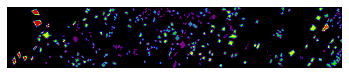

In [9]:
base_net=BaseNet(N_BANDS,N_CLASSES)
critirian=nn.CrossEntropyLoss().cuda()
lr=0.05
epochs=300
optimizer=torch.optim.SGD(base_net.parameters(),lr=lr,weight_decay=0.0001)
best_acc=0
kappa=0
cls_report=''
train_acc_list=[]
test_acc_list=[]
tic0 = time.perf_counter()
train(base_net,optimizer,critirian,train_loader,val_loader,epochs)
toc0 = time.perf_counter()
time_train = toc0 - tic0

tic = time.perf_counter()
number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())
toc = time.perf_counter()
time_test = toc - tic
predicts = predicts.tolist()

targets = targets.tolist()
acc = accuracy_score(predicts, targets)
test_acc_list.append(acc)
toc = time.perf_counter()
time_test = toc - tic
print('test-------')
# print('Epoch:', epoch)
print('test Acc:', acc)
kappa = cohen_kappa_score(predicts, targets)
print('Kappa', kappa)
con_matrics = confusion_matrix(predicts, targets)
each_acc, aa = AA_andEachClassAccuracy(con_matrics)
cls_report = classification_report(predicts, targets, digits=4)
#         print(con_matrics)
#         print(cls_report)
print('aa:',aa)
print('each acc:',each_acc)
print('train time:',time_train)
print('test time:',time_test)

X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()


# classification maps for all pixels in the image

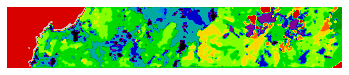

In [10]:
y_temp = np.ones_like(gt)
all_dataset = HSIdata(img,y_temp)
all_map_loader = torch.utils.data.DataLoader(all_dataset,
                               batch_size=256,
                               shuffle=True)

number = 0
correct = 0
predicts = np.zeros((0))
targets = np.zeros((0))
indicesX = []
indicesY = []
with torch.no_grad():
    for iter_, (data, target,x,y) in enumerate(all_map_loader):
        data, target = data.to(device), target.to(device)
        base_net.eval()
        output = base_net(data)
        _, predict = torch.max(output.data, 1)
        predict = predict.cpu().numpy()
        target = target.cpu().numpy()
        predicts = np.append(predicts, predict)
        targets = np.append(targets, target)
        indicesX.extend(x.cpu().numpy().tolist())
        indicesY.extend(y.cpu().numpy().tolist())

predicts = predicts.tolist()
X = np.array(indicesX)
Y = np.array(indicesY)
test_img = gt
predicts_cor = [i+1 for i in predicts]
test_img[X[:], Y[:]] = np.array(predicts_cor)
plt.imshow(test_img, cmap='nipy_spectral')
plt.axis('off')
# plt.title("epoch:{}".format(epoch))
plt.show()
# io.savemat( dataset_name + '_classmap.mat', {"classes_map": test_img})


# model complexity

In [12]:
# input_x = torch.randn(1, N_BANDS, 13, 13)
# input_x = input_x.cuda()
# macs,_ = profile(base_net, inputs=(input_x, ))
# print("MACs are about",macs,'and should add the MACs of NAPF manually, the rules of that can refer the paper')
# summary(base_net, input_size=(N_BANDS,13,13))